### Import the Dependencies

In [11]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.kernel_approximation import Nystroem
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.classifier import ROCAUC

### Data Preprocessing

In [12]:
df = pd.read_csv('/Users/jarkrunglerdkriangkrai/ISE/Year 4/Semester 2/Big Data/new_github/big_data_ai/imdp.csv',encoding='latin-1')

# Count the frequency of each IMDb score
score_count = dict(df['imdb_score'].value_counts())

# Sort the scores in descending order of frequency
score_count = {k: v for k, v in sorted(score_count.items(), key=lambda item: item[1], reverse=True)}

# Separate numerical and categorical columns
num_columns = [c for c in df.columns if df[c].dtype in ['float64', 'int64']]
cat_columns = [c for c in df.columns if c not in num_columns]

# Remove scores of 6.6, 6.7, and 6.8
remove_score = {6.6, 6.7, 6.8}
float_df = df[num_columns].astype('float64')
float_df = float_df[~float_df['imdb_score'].isin(remove_score)]
float_df['imdb_score'] = float_df['imdb_score'].apply(lambda x: 0 if x < 6.6 else 1)

# Split the data into training and testing sets
x = float_df.drop(['imdb_score'], axis=1)
y = float_df['imdb_score']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# Impute missing values with median and scale the features
imp = SimpleImputer(strategy='median')
x_train = pd.DataFrame(imp.fit_transform(x_train), columns=x.columns)
x_test = pd.DataFrame(imp.transform(x_test), columns=x.columns)
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)

In [20]:
df.head()

,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,actor_1_name,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,Johnny Depp,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,Christoph Waltz,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,Tom Hardy,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,Doug Walker,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


### Gridsearch

- kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
- degree: int, default=3
-   Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
- gamma: {‘scale’, ‘auto’} or float, default=’scale’
- coef0: float, default=0.0
- C: float, default=1.0  Regularization parameter. (bigger value tables more time to train)
- cache_size: float, default=200 (MB, if you have enough RAM use a bigger value)
- max_iter: int, default=-1

In [13]:
kernels = ['linear', 'rbf', 'sigmoid']
gammas = ['scale', 'auto']
Cs = [0, 0.1, 1, 10, 20, 100]

In [14]:
param_dict = dict(kernel = kernels, gamma = gammas, C = Cs)
grid = GridSearchCV(estimator = SVC(cache_size = 500), param_grid = param_dict, cv = 10, scoring = 'roc_auc') 
grid_result = grid.fit(x_train, y_train)
print('Best Score: ', grid_result.best_score_) 
print('Best Params: ', grid_result.best_params_)

/Users/jarkrunglerdkriangkrai/opt/anaconda3/envs/bigdata/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jarkrunglerdkriangkrai/opt/anaconda3/envs/bigdata/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jarkrunglerdkriangkrai/opt/anaconda3/envs/bigdata/lib/python3.9/site-packages/sklearn/svm/_base.py", line 251, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/Users/jarkrungl

Best Score:  0.8727540251654485
Best Params:  {'C': 20, 'gamma': 'scale', 'kernel': 'rbf'}


### Interpreting the Result

In [15]:
clf = SVC(kernel = 'rbf', gamma = 'scale', C = 20, cache_size = 500)
clf.fit(x_train, y_train)

SVC(C=20, cache_size=500)

In [16]:
y_pred = pd.DataFrame(clf.predict(x_test))

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.91      0.85       515
           1       0.85      0.67      0.75       373

    accuracy                           0.81       888
   macro avg       0.82      0.79      0.80       888
weighted avg       0.82      0.81      0.81       888

Accuracy on the training set: 0.853

Accuracy on the test set: 0.811



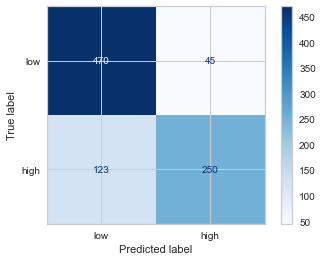

In [17]:
print("Classification Report: \n", metrics.classification_report(y_test, y_pred))
print(f"Accuracy on the training set: {clf.score(x_train, y_train).round(3)}\n")
print(f"Accuracy on the test set: {clf.score(x_test, y_test).round(3)}\n")
cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(cm, display_labels = ['low', 'high'])
disp.plot(cmap = 'Blues')
plt.show()

/Users/jarkrunglerdkriangkrai/opt/anaconda3/envs/bigdata/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


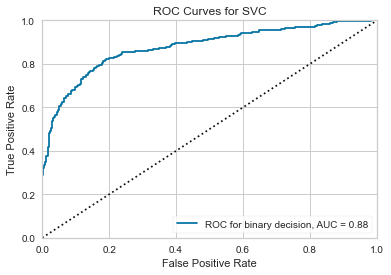

<AxesSubplot: title={'center': 'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [18]:
visualizer = ROCAUC(clf, classes = ['low', 'high'], binary = True)
visualizer.fit(x_train, y_train)        
visualizer.score(x_test, y_test)        
visualizer.show()  

In [19]:
print(f'dual coef length for first class: {len(clf.dual_coef_[0][0: clf.n_support_[0]])}') 
print(f'dual coef length for second class: {len(clf.dual_coef_[0][clf.n_support_[0]: ])}') 
print(clf._intercept_)
print(clf.n_support_) # first value for first class and so on
print(len(clf.support_vectors_)) # total number of support vectors

dual coef length for first class: 849
dual coef length for second class: 872
[-0.89103761]
[849 872]
1721
